# StackOverflow EDA

This document presented some exploritory analysis on the non-text files for all questions up to December 2017 data cut.

In [39]:
import re
import string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta
from collections import Counter
from itertools import chain

from scipy.spatial.distance import cosine
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 

Datasets used in this workbook:

   * `Question_info.csv` - StackOverflow Questions up-to December 3rd, 2017 (excluding body and title columns)
   * `Answer_info.csv` - StackOverflow Answers
   * `Question_Txt_2017.csv` - StackOverflow Questions title and textbody data in 2017.

In [2]:
%%time
file_path = "/Volumes/DockerDrive/"
questions = pd.read_csv(file_path+"question_info.csv", index_col="CreationDate", 
                        parse_dates=["CreationDate", "LastActivityDate", "ClosedDate"])
answers = pd.read_csv(file_path+"answer_info.csv", parse_dates=["CreationDate", "LastActivityDate"])
questions_text = pd.read_csv(file_path+"question_txt_2017.csv")

CPU times: user 3min 42s, sys: 1min 28s, total: 5min 10s
Wall time: 5min 37s


In [3]:
questions.head()

,Id,Tags,LastActivityDate,ClosedDate,AnswerCount,CommentCount,FavoriteCount,ViewCount,Score,AcceptedAnswerId,OwnerUserId
CreationDate,,,,,,,,,,,
2008-07-31 21:42:52.667,4,<c#><winforms><type-conversion><decimal><opacity>,2017-09-27 05:52:59.927,NaT,13,1,37,33648,528,7,8
2008-07-31 22:08:08.620,6,<html><css><css3><internet-explorer-7>,2016-03-19 06:10:52.170,NaT,5,0,9,15363,231,31,9
2008-07-31 23:40:59.743,9,<c#><.net><datetime>,2017-11-07 11:12:32.963,NaT,61,10,356,417633,1624,1404,1
2008-07-31 23:55:37.967,11,<c#><datetime><time><datediff><relative-time-s...,2017-09-04 01:27:10.793,NaT,34,3,526,126480,1234,1248,1
2008-08-01 00:42:38.903,13,<javascript><html><browser><timezone><timezone...,2017-07-31 11:30:41.573,NaT,24,4,127,146275,512,0,9


In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14995834 entries, 2008-07-31 21:42:52.667000 to 2017-12-03 05:01:10.747000
Data columns (total 11 columns):
Id                  int64
Tags                object
LastActivityDate    datetime64[ns]
ClosedDate          datetime64[ns]
AnswerCount         int64
CommentCount        int64
FavoriteCount       int64
ViewCount           int64
Score               int64
AcceptedAnswerId    int64
OwnerUserId         int64
dtypes: datetime64[ns](2), int64(8), object(1)
memory usage: 1.3+ GB


In [5]:
questions.describe()

,Id,AnswerCount,CommentCount,FavoriteCount,ViewCount,Score,AcceptedAnswerId,OwnerUserId
count,1.499583e+07,1.499583e+07,1.499583e+07,1.499583e+07,1.499583e+07,1.499583e+07,1.499583e+07,1.499583e+07
mean,2.515378e+07,1.560372e+00,1.941911e+00,5.896048e-01,1.982496e+03,1.899071e+00,1.215025e+07,2.615097e+06
std,1.364082e+07,1.456391e+00,2.661000e+00,9.233417e+00,1.452354e+04,1.957909e+01,1.503338e+07,2.271817e+06
min,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.470000e+02,0.000000e+00,0.000000e+00
25%,1.343999e+07,1.000000e+00,0.000000e+00,0.000000e+00,7.200000e+01,0.000000e+00,0.000000e+00,7.470200e+05
50%,2.555962e+07,1.000000e+00,1.000000e+00,0.000000e+00,2.400000e+02,0.000000e+00,3.347702e+06,1.902689e+06
75%,3.712203e+07,2.000000e+00,3.000000e+00,0.000000e+00,9.020000e+02,1.000000e+00,2.361232e+07,4.094661e+06
max,4.761543e+07,5.180000e+02,1.190000e+02,9.309000e+03,5.686549e+06,1.990400e+04,4.761540e+07,9.045401e+06


In [6]:
answers.head()

,Id,CreationDate,LastActivityDate,CommentCount,Score,OwnerUserId,ParentId
0,7,2008-07-31 22:17:57.883,2012-10-14 11:50:16.703,0,379,9,4
1,12,2008-07-31 23:56:41.303,2014-02-18 14:19:35.770,10,312,1,11
2,18,2008-08-01 05:12:44.193,2016-06-02 05:56:26.060,2,45,0,17
3,21,2008-08-01 08:57:27.280,2008-08-01 12:35:11.707,0,31,13,9
4,22,2008-08-01 12:07:19.500,2008-08-01 15:26:37.087,0,24,17,9


In [110]:
questions_text.head(10)

,Id,Body,Title,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,has_questionmark,is_question
0,41412454,<p>I have a problem with the following piece o...,Update on 2 or more tables,3,2,2,7,0,0,3,False,False
1,41412456,"<p>I am using fabric, which is a deployment to...",A expect script with multiple shell statements,5,5,1,11,0,0,6,False,False
2,41412462,"<p>To recreate the issue, I forked the Angular...",While bootstrapping a hybrid angular 1 + 2 app...,10,6,5,22,0,0,11,True,True
3,41412463,<p>I have a global variable\r\n<code>global.lo...,Is Javascript's setInterval killed when the pa...,4,7,2,13,0,0,7,True,True
4,41412466,<p>I have an android app to show <code>Karaoke...,Adapter not notifyDataSetChanged immediately?,5,7,2,14,0,1,3,True,True
5,41412468,<p>I'm trying to wrap my head around an MySQL ...,Column name as Boolean? What does it mean?,9,8,4,24,0,2,5,True,True
6,41412470,<p>I have an array and when I try to append a ...,Appending a string to each item of an array,5,3,3,11,0,0,4,False,False
7,41412471,<p>I just started working with Tableau and I f...,Tableau: how can I filter dimensions/metrics o...,5,0,0,5,0,0,9,False,True
8,41412472,"<p><img src=""https://i.stack.imgur.com/FAKFs.p...",How can I change the background-color in betwe...,3,6,0,9,0,0,7,True,True
9,41412475,<p>I'm making a clickable dropdown menu. But w...,"javascript only works in <script> tags, not js...",1,1,1,3,0,0,6,False,False


## Question Creation Time  

In this section, we are looking at creation time for each question, and to see any trend we might observe.

In [8]:
pd.Series(questions.index.values).describe()

count                       14995834
unique                      14993243
top       2017-05-09 08:21:26.633000
freq                               3
first     2008-07-31 21:42:52.667000
last      2017-12-03 05:01:10.747000
dtype: object

First, we can take quickly perform a weekly question counts.

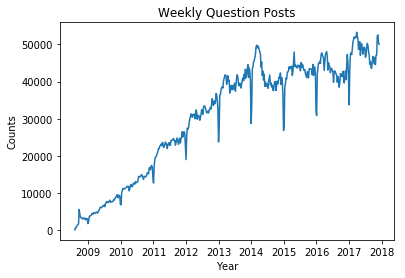

In [9]:
weekly_date_freq = questions['Id'].resample('W').count()
_ = plt.plot(weekly_date_freq)
_ = plt.xlabel('Year')
_ = plt.ylabel('Counts')
_ = plt.title('Weekly Question Posts')
plt.show()

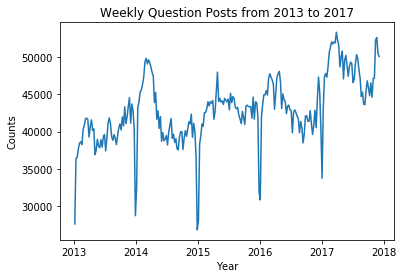

In [10]:
_ = plt.plot(weekly_date_freq["2013":"2017"])
_ = plt.xlabel('Year')
_ = plt.ylabel('Counts')
_ = plt.title('Weekly Question Posts from 2013 to 2017')
plt.show()

There seems to be a steady increasing counts of weekly question plots from 2008 when the website just got created and in late 2013 when the growth slowed down and a constant number of questions coming in each of the week.  
Zoom-in to 2013 - 2017 time window, we can see a pattern that at end of the year, weekly question counts will drop to around 30,000, probably due to holidays. However it's still around 75% of the peak weeks! People are really working hard to contribute to the community, even during holidays. 
Next, we zoom in to median question counts within a week, summarized for 2013 to 2017 time period at hourly frequency.

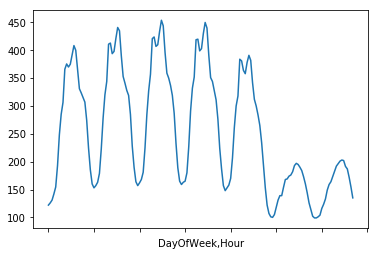

In [11]:
hourly_freq_13_17 = questions["2013":"2017"].Id.resample('H').count()
hourly_freq_13_17_df = pd.DataFrame(hourly_freq_13_17)
hourly_freq_13_17_df.columns = ['Count']
hourly_freq_13_17_df['DayOfWeek'] = hourly_freq_13_17.index.dayofweek
hourly_freq_13_17_df['Hour'] = hourly_freq_13_17.index.hour
median_hourly_freq_13_17 = hourly_freq_13_17_df.groupby(['DayOfWeek', 'Hour']).Count.median()
median_hourly_freq_13_17.plot()
plt.show()

There is an interest weekly pattern that people definitely submited more questions on weekdays than weekends! Among weekdays, Friday seems to have the lowest counts, followed by Mondays. This is very true for lifes for programming working professionals. TGIF! OGIF!  
Since the different seems small, we can later on run a statistical test on it.  
Further we might want to aggregate weekdays and days on weekends.

In [12]:
weekday_hourly = hourly_freq_13_17_df[hourly_freq_13_17_df.DayOfWeek<5].groupby('Hour').Count.median()
weekend_hourly = hourly_freq_13_17_df[hourly_freq_13_17_df.DayOfWeek>=5].groupby('Hour').Count.median()

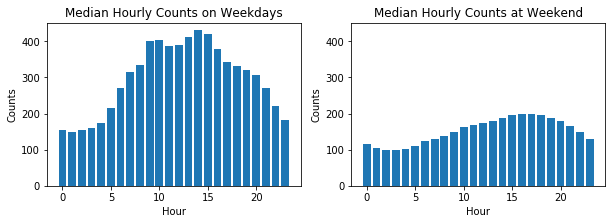

In [13]:
plt.subplots(figsize=(10, 3))
ax = plt.subplot(121)
plt.bar(weekday_hourly.index, weekday_hourly)
plt.xlabel('Hour')
plt.ylabel('Counts')
plt.title('Median Hourly Counts on Weekdays')
plt.subplot(122, sharey=ax)
plt.bar(weekend_hourly.index, weekend_hourly)
plt.xlabel('Hour')
plt.ylabel('Counts')
plt.title('Median Hourly Counts at Weekend')
plt.show()

Weekday posts are more concentrated at UTC 08:00 to 20:00. While weekend posts are more spread out for the day.

## Answer Timing

Here we are looking at static answer counts as of 12/03/2017, like a snapshot of as of that day. This is an easy way to give us insights on how fast usually a question can be answered over long scale of time without data merging. 

In [14]:
questions.AnswerCount.describe()

count    1.499583e+07
mean     1.560372e+00
std      1.456391e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.180000e+02
Name: AnswerCount, dtype: float64

In [15]:
np.sum(questions.AnswerCount == 0)/questions.shape[0]

0.1313654178887283

13% of questions have not received any answers. Break it up by time of the question creation.

In [17]:
def get_answer_pct(array_like):
    return (np.sum(array_like > 0)/len(array_like))
question_answer_pct = questions.resample('W').AnswerCount.apply(get_answer_pct)

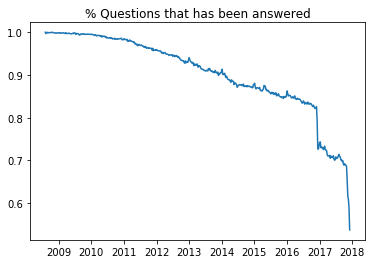

In [18]:
plt.plot(question_answer_pct)
plt.title("% Questions that has been answered")
plt.show()

The longer a question being posted, the more likely it got answered. More than 80% of questions posted before 2017 were answered and around 70% for questions asked during 2017. There seems to be drops at the tail. We can further zoom-in.

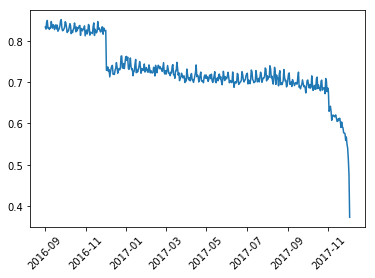

In [19]:
question_answer_pct_D = questions["2016-09":"2017-12"].resample('D').AnswerCount.apply(get_answer_pct)
plt.plot(question_answer_pct_D)
plt.xticks(rotation=45)
plt.show()

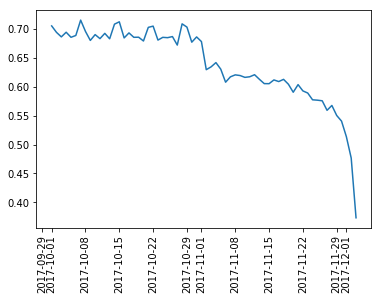

In [20]:
plt.plot(question_answer_pct_D["2017-10":"2017-12"])
plt.xticks(rotation=90)
plt.show()

In December 2017, it seems something happened that fewer questions may receive answers for that reason. So far there is no good theory, but one of the reason could be some question closure or moderation by bot, so a good number of questions would never get answers. But so far I found no easy way to verify that.  
But look at a even smaller time window, about 60% of questions are expected to be answered within a month, but after a month, very few of them are expected to get an answer any more! Meanwhile, about 40% of questions on 12/03 got an answer on the same day! 
We cannot further zoom-in on this plot. Let's merge with Answers dataset to get more insights.

In [55]:
answers.rename(columns = {"CreationDate": "AnswerDate"}, inplace = True)
q_and_a = pd.merge(questions.reset_index()[['CreationDate', 'Id', 'AcceptedAnswerId']], 
                  answers[['Id', 'AnswerDate', 'ParentId']].groupby('ParentId').min(), 
                  how = "left", left_on = "Id", right_on = "ParentId", suffixes=('', 'Answer'))
q_and_a.rename(columns={"AnswerDate":"FirstAnswerDate"},inplace=True)
q_and_a = pd.merge(q_and_a,
                  answers[['Id', 'AnswerDate']], 
                  how = "left", left_on = "AcceptedAnswerId", right_on = "Id", suffixes=('', 'AcceptedAnswer'))
q_and_a.rename(columns={"AnswerDate":"FirstAcceptedAnswerDate"},inplace=True)
q_and_a.head()

,CreationDate,Id,AcceptedAnswerId,IdAnswer,FirstAnswerDate,IdAcceptedAnswer,FirstAcceptedAnswerDate
0,2008-07-31 21:42:52.667,4,7,7.0,2008-07-31 22:17:57.883,7.0,2008-07-31 22:17:57.883
1,2008-07-31 22:08:08.620,6,31,31.0,2008-08-01 12:22:51.593,31.0,2008-08-01 12:22:51.593
2,2008-07-31 23:40:59.743,9,1404,21.0,2008-08-01 08:57:27.280,1404.0,2008-08-04 16:50:06.170
3,2008-07-31 23:55:37.967,11,1248,12.0,2008-07-31 23:56:41.303,1248.0,2008-08-04 13:57:26.097
4,2008-08-01 00:42:38.903,13,0,29.0,2008-08-01 12:19:17.417,NaN,NaT


In [56]:
q_and_a['TimeToFirstAnswer'] = (q_and_a['FirstAnswerDate'] - q_and_a['CreationDate'])
q_and_a['TimeToFirstAcceptedAnswer'] = q_and_a['FirstAcceptedAnswerDate'] - q_and_a['CreationDate']
# clean out 451 negative values, and 32514 rows with answer date == creation date
q_and_a = q_and_a[~(((pd.to_numeric(q_and_a['TimeToFirstAnswer']) <= 0) & (q_and_a['TimeToFirstAnswer'].notna())) |
       ((pd.to_numeric(q_and_a['TimeToFirstAcceptedAnswer']) <= 0) & (q_and_a['TimeToFirstAcceptedAnswer'].notna())))]

In [57]:
q_and_a.head()

,CreationDate,Id,AcceptedAnswerId,IdAnswer,FirstAnswerDate,IdAcceptedAnswer,FirstAcceptedAnswerDate,TimeToFirstAnswer,TimeToFirstAcceptedAnswer
0,2008-07-31 21:42:52.667,4,7,7.0,2008-07-31 22:17:57.883,7.0,2008-07-31 22:17:57.883,00:35:05.216000,0 days 00:35:05.216000
1,2008-07-31 22:08:08.620,6,31,31.0,2008-08-01 12:22:51.593,31.0,2008-08-01 12:22:51.593,14:14:42.973000,0 days 14:14:42.973000
2,2008-07-31 23:40:59.743,9,1404,21.0,2008-08-01 08:57:27.280,1404.0,2008-08-04 16:50:06.170,09:16:27.537000,3 days 17:09:06.427000
3,2008-07-31 23:55:37.967,11,1248,12.0,2008-07-31 23:56:41.303,1248.0,2008-08-04 13:57:26.097,00:01:03.336000,3 days 14:01:48.130000
4,2008-08-01 00:42:38.903,13,0,29.0,2008-08-01 12:19:17.417,NaN,NaT,11:36:38.514000,NaT


Take a look at the distribution of TimeToFirstAnswer and TimeToFirstAcceptedAnswer variables.

In [58]:
q_and_a['TimeToFirstAnswer'].describe()

count                     12992935
mean       12 days 06:38:50.816131
std        79 days 16:10:55.452713
min         0 days 00:00:00.110000
25%         0 days 00:07:23.063000
50%         0 days 00:26:20.680000
75%         0 days 04:11:23.824500
max      3194 days 04:13:59.513000
Name: TimeToFirstAnswer, dtype: object

In [59]:
sum(q_and_a['TimeToFirstAnswer'].isna())/q_and_a.shape[0]

0.13165483170373277

In [60]:
timecuts = [timedelta(minutes=1), timedelta(minutes=10), timedelta(hours=1), 
            timedelta(hours=6), timedelta(days=1), timedelta(days=7), timedelta(days=30)]
[sum((q_and_a['TimeToFirstAnswer'].notna()) & 
     (q_and_a['TimeToFirstAnswer'] <= tc))/q_and_a.shape[0] for tc in timecuts]

[0.0024911666338855204,
 0.27448693161719184,
 0.5344947549831519,
 0.672166881899454,
 0.7452763905104027,
 0.802685768350976,
 0.8264826083821224]

In [61]:
timecuts = [timedelta(minutes=i) for i in range(1, 60)]
cum_pct_a = [sum((q_and_a['TimeToFirstAnswer'].notna()) & 
                 (q_and_a['TimeToFirstAnswer'] <= tc))/q_and_a.shape[0] for tc in timecuts]

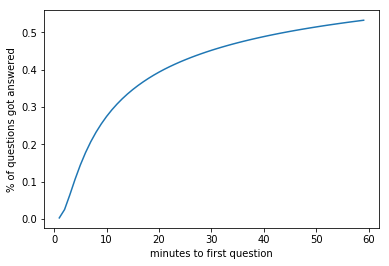

In [62]:
plt.plot([td/timecuts[0] for td in timecuts], cum_pct_a)
plt.xlabel('minutes to first question')
plt.ylabel('% of questions got answered')
plt.show()

This looks like an very interesting distribution. We can see 50% of questions can get an answered within one hour! 30% of them got answered even within 10 minutes.
Statistically, this is not expotential, not even weibull. Perform a log-log plot of F(x) against log(x), to demonstrate it's not a weibull.

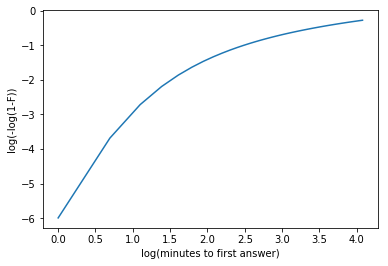

In [63]:
plt.plot(np.log(np.arange(1,60)), np.log((-1)*np.log(1-np.array(cum_pct_a))))
plt.xlabel('log(minutes to first answer)')
plt.ylabel('log(-log(1-F))')
plt.show()

The platform has been developped for many years. The next question would be if the rate of answer is stable across years.

In [64]:
q_and_a['Year'] = q_and_a['CreationDate'].dt.year

In [65]:
plot_data = pd.concat([q_and_a.groupby('Year')['TimeToFirstAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(1, 60)])

In [66]:
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['Year', 'Minutes', 'Cumulative_Percentage']

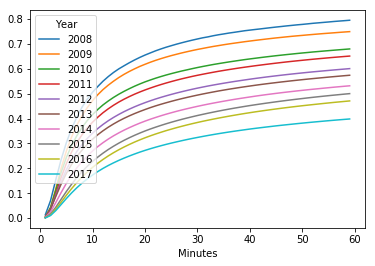

In [67]:
plot_data.pivot(index='Minutes', columns='Year', values='Cumulative_Percentage').plot()
plt.show()

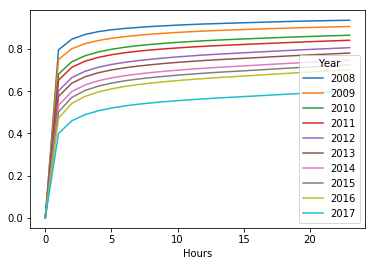

In [68]:
plot_data_a2 = pd.concat([q_and_a.groupby('Year')['TimeToFirstAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(hours = i))), [i])) for i in range(0, 24)])
plot_data_a2 = pd.DataFrame(plot_data_a2).reset_index()
plot_data_a2.columns = ['Year', 'Hours', 'Cumulative_Percentage']
plot_data_a2.pivot(index='Hours', columns='Year', values='Cumulative_Percentage').plot()
plt.show()

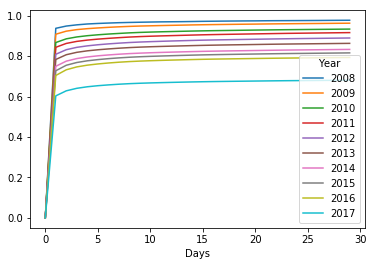

In [69]:
plot_data_a3 = pd.concat([q_and_a.groupby('Year')['TimeToFirstAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(days = i))), [i])) for i in range(0, 30)])
plot_data_a3 = pd.DataFrame(plot_data_a3).reset_index()
plot_data_a3.columns = ['Year', 'Days', 'Cumulative_Percentage']
plot_data_a3.pivot(index='Days', columns='Year', values='Cumulative_Percentage').plot()
plt.show()

The percentage of questions answered within an hour dropped from 80% in 2008 to 35% in 2017. A couple of reasons can cause this problem. Growing user base doesn't mean growing quality of the content. There are centain topics well covered in a question post in the past, then people are running out of good questions on that topic, and more likely to result in duplicated questions.  
We reproduce the same set of plots for `TimeToFirstAcceptedAnswer`.

In [70]:
cum_pct_aa = [sum((q_and_a['TimeToFirstAcceptedAnswer'].notna()) & 
                  (q_and_a['TimeToFirstAcceptedAnswer'] <= tc))/q_and_a.shape[0] for tc in timecuts]

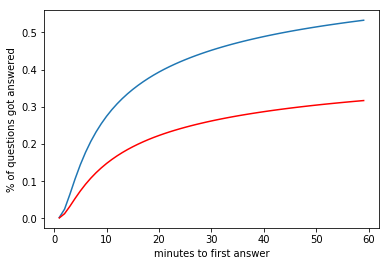

In [71]:
plt.plot(np.arange(1, 60), cum_pct_a, label = "First Answer")
plt.plot(np.arange(1, 60), cum_pct_aa, color = "red", label = "First Accepted Answer")
plt.xlabel('minutes to first answer')
plt.ylabel('% of questions got answered')
plt.show()

30% of questions will get a reasonable answer and got accepted. But that's an average across all years.

In [72]:
plot_data_aa = pd.concat([q_and_a.groupby('Year')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(1, 60)])
plot_data_aa = pd.DataFrame(plot_data_aa).reset_index()
plot_data_aa.columns = ['Year', 'Minutes', 'Cumulative_Percentage']

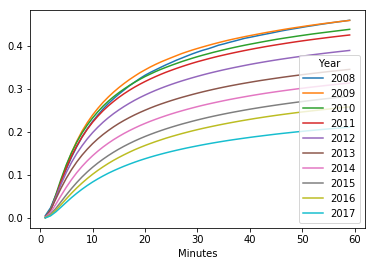

In [73]:
plot_data_aa.pivot(index='Minutes', columns='Year', values='Cumulative_Percentage').plot()
plt.show()

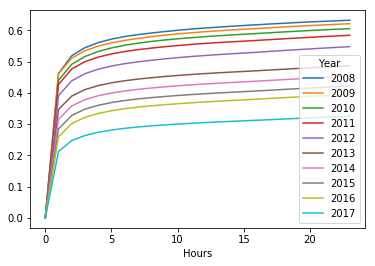

In [74]:
plot_data_aa2 = pd.concat([q_and_a.groupby('Year')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(hours = i))), [i])) for i in range(0, 24)])
plot_data_aa2 = pd.DataFrame(plot_data_aa2).reset_index()
plot_data_aa2.columns = ['Year', 'Hours', 'Cumulative_Percentage']
plot_data_aa2.pivot(index='Hours', columns='Year', values='Cumulative_Percentage').plot()
plt.show()

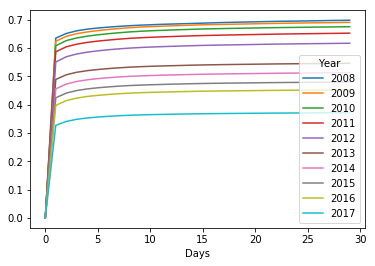

In [75]:
plot_data_aa3 = pd.concat([q_and_a.groupby('Year')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(days = i))), [i])) for i in range(0, 30)])
plot_data_aa3 = pd.DataFrame(plot_data_aa3).reset_index()
plot_data_aa3.columns = ['Year', 'Days', 'Cumulative_Percentage']
plot_data_aa3.pivot(index='Days', columns='Year', values='Cumulative_Percentage').plot()
plt.show()

We can observe approximately the same secular trend. If one question does not get an answer within one day or two, it will be very hard to find an good answer to that question. The rate in 2017 is much lower than 2016, possibily due to the same drop we observed, and hypothetically result from moderation.

## Other Quality Measures - ViewCount, Score, FavoriteCount

There are some other measures of post quality. Those measures heavily depend on how long a post being posted, thus need proper adjustment of the time effect to be useful.

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


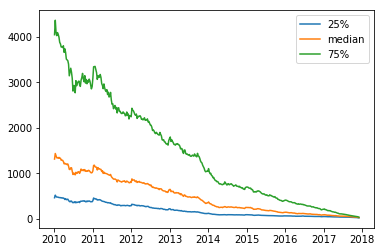

In [191]:
median_weekly_viewcount = questions.resample('W').ViewCount.agg({
    '25%': lambda x: x.quantile(0.25), 
    'median': np.median, 
    '75%': lambda x: x.quantile(0.75)})
plt.plot(median_weekly_viewcount["2010":"2017"])
plt.legend(labels=median_weekly_viewcount.columns, loc='upper right')
plt.show()

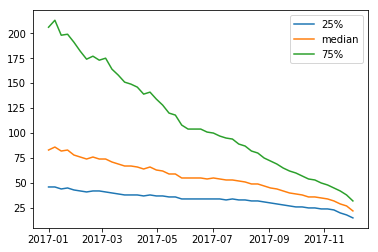

In [192]:
plt.plot(median_weekly_viewcount["2017":"2017"])
plt.legend(labels=median_weekly_viewcount.columns, loc='upper right')
plt.show()

View Counts grow quite linearly by time of exposure.

In [193]:
pd.cut(questions.Score, bins=[float("-inf"), -1, 0, 1, 10, 100, float("inf")],
                    labels=["neg", "0", "1", "1-10", "10-100", "100+"]).value_counts(sort = False)

neg        998126
0         6965492
1         3331888
1-10      3294526
10-100     382276
100+        23526
Name: Score, dtype: int64

There are almost 1m questions with negative score! Even some of them might get answered, those are probably concerning questions. Meanwhile 7m questions are with zero score.

Look at scatter matrix of four measures.

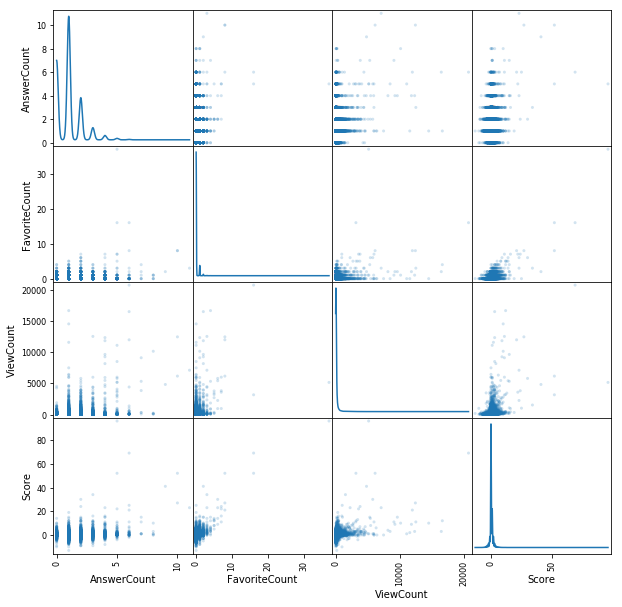

In [197]:
#questions['logAnswerCount'] = np.log10(questions['AnswerCount'] + 1)
#questions['logFavoriteCount'] = np.log10(questions['FavoriteCount'] + 1)
#questions['logViewCount'] = np.log10(questions['ViewCount'] + 1)
pd.plotting.scatter_matrix(questions['2017'][['AnswerCount', 'FavoriteCount', 'ViewCount', 'Score']].sample(frac = 0.01),
                          alpha=0.2, figsize=(10, 10), diagonal='kde', marker=".")
plt.show()

## Tags

Tags give us information about question topic area. But there are over 50,000 tags, and some tags are just so strongly associated, such as 'html' with 'html5', 'css', 'css3'.  
Perform a quick clustering analysis will help us remove redundent tags.

In [8]:
# convert tag strings into a list
def parse_tags(tags_str):
    return list(filter(None, re.split('<|>', tags_str)))
tags_list = [parse_tags(item) for item in questions.Tags]

In [9]:
tags_flatten = list(chain.from_iterable(tags_list))
counter = Counter(tags_flatten)

In [10]:
len(counter)

50812

In [11]:
counter.most_common(30)

[('javascript', 1519856),
 ('java', 1347905),
 ('c#', 1161039),
 ('php', 1147786),
 ('android', 1053069),
 ('jquery', 884587),
 ('python', 861581),
 ('html', 710088),
 ('c++', 545586),
 ('ios', 541257),
 ('css', 508413),
 ('mysql', 496302),
 ('sql', 417064),
 ('asp.net', 326667),
 ('ruby-on-rails', 284665),
 ('objective-c', 281587),
 ('c', 266251),
 ('.net', 261476),
 ('arrays', 247682),
 ('angularjs', 246016),
 ('json', 219199),
 ('sql-server', 218851),
 ('iphone', 218560),
 ('r', 213835),
 ('node.js', 202665),
 ('ruby', 189763),
 ('ajax', 180110),
 ('regex', 179264),
 ('swift', 173107),
 ('xml', 166778)]

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


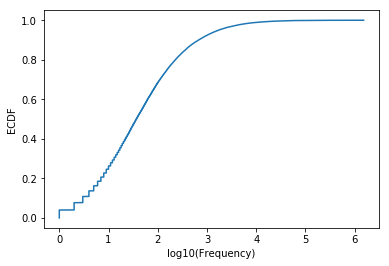

In [12]:
ecdf = ECDF(np.array(list(counter.values())))
plt.plot(np.log10(ecdf.x), ecdf.y)
plt.xlabel('log10(Frequency)')
plt.ylabel('ECDF')
plt.show()

Most tags were not frequently used. About 90% of tags only been used for < 1000 times. 
We demonstrate top 10 tags frequency by year.  

In [13]:
plot_lst = []
for year in range(2008, 2017):
    tags_list_y = [parse_tags(item) for item in questions[str(year)].Tags]
    tags_flatten_y = list(chain.from_iterable(tags_list_y))
    counter_y = Counter(tags_flatten_y)
    common_y = pd.DataFrame(np.array(counter_y.most_common(10)))
    common_y.columns = ['Tag', 'Freq']
    common_y['year'] = year
    plot_lst.append(common_y)
plot_df = pd.concat(plot_lst)
plot_df['year'] = plot_df['year'].astype('category')
plot_df['Freq'] = plot_df['Freq'].astype('int')

/Users/ouou/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


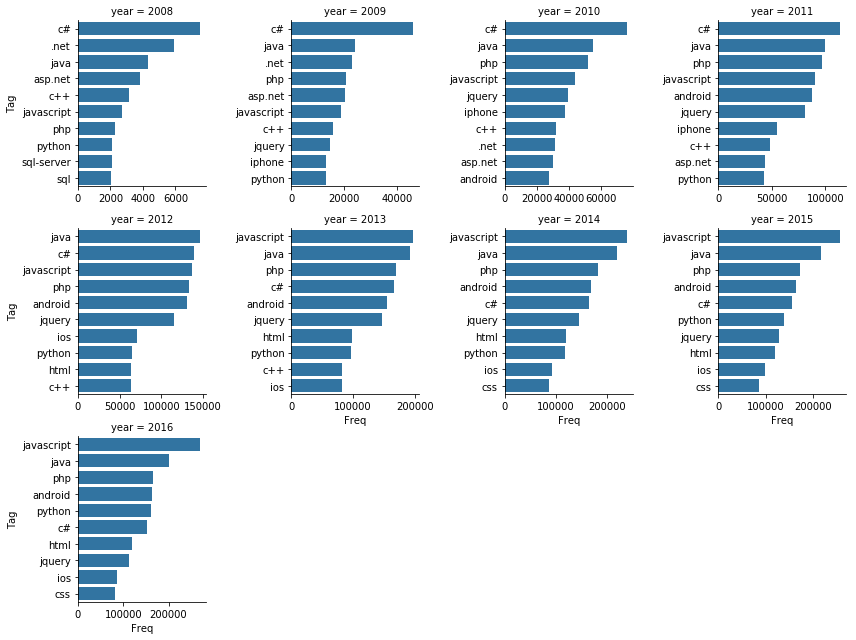

In [14]:
g = sns.FacetGrid(plot_df, col='year', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.barplot, "Freq", "Tag", orient='h')
plt.show()

`C#` was once the most popular, but was replaced by `java`, and then `javascript` in 2013. `java` and `php` are all-time favorites. 

Further we can take a look at the trend of question posts by tags (top 30 tags).

In [22]:
common = np.array(counter.most_common(30))[:,0]
common

array(['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python',
       'html', 'c++', 'ios', 'css', 'mysql', 'sql', 'asp.net',
       'ruby-on-rails', 'objective-c', 'c', '.net', 'arrays', 'angularjs',
       'json', 'sql-server', 'iphone', 'r', 'node.js', 'ruby', 'ajax',
       'regex', 'swift', 'xml'], dtype='<U13')

In [15]:
# convert tag strings into a document split by space
def parse_tags_doc(tags_str):
    return ' '.join(filter(None, re.split('<|>', tags_str)))
tags_doc_list = [parse_tags_doc(item) for item in questions.Tags]

In [16]:
cv = CountVectorizer(min_df=1000, max_features=30, token_pattern='\S+')
counts = cv.fit_transform(tags_doc_list)
words = np.array(cv.get_feature_names()) 

In [17]:
counts_df = pd.DataFrame(pd.SparseDataFrame(counts))
counts_df.columns = words
counts_df['CreationTime'] = questions.index.values
counts_df = counts_df.reset_index().set_index('CreationTime').drop('index', axis = 1)
#weekly_counts = counts_df.resample('W').sum()

In [25]:
weekly_plot_list=[]
for i, item in enumerate(common):
    weekly_plot_list.append(counts_df[item][counts_df[item] == 1].resample('W').count())

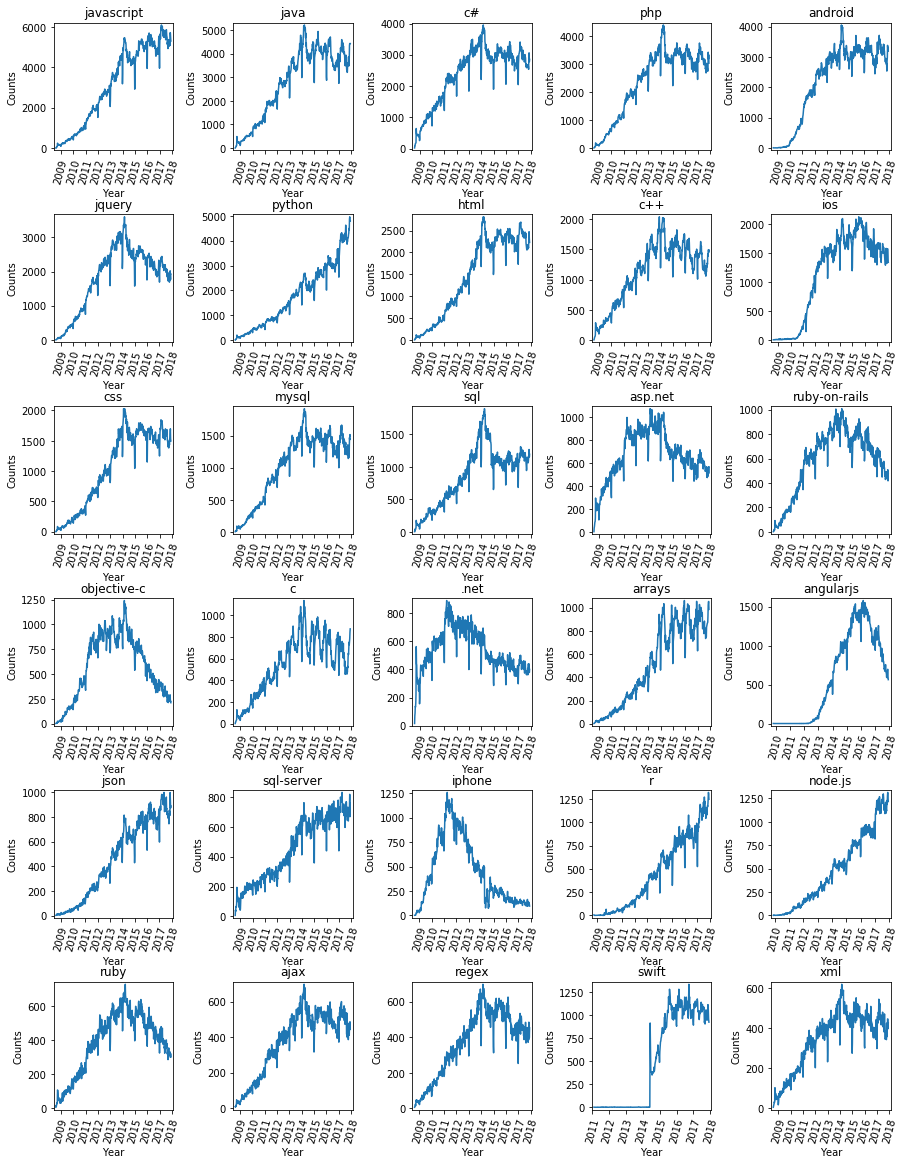

In [34]:
fig, ax = plt.subplots(figsize = (15, 20))   
fig.subplots_adjust(hspace=.5, wspace=.5)
for i, item in enumerate(common):    
    plt.subplot(6, 5, i + 1)
    plt.margins(0.02)
    plt.plot(weekly_plot_list[i])
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.xticks(rotation=75)
    plt.title(item)
plt.show()
savefig('trend_by_tag.png')

A lot interesing stories we can read from it --
Some tags stays popular, such as `javascript`, `java`, `c#`, `php`.  
Some tags are losing popularity, such as `jquery`, `objective-c`, `.net`, `ruby`, `iphone`
Some tags are new to the community, such as `android` and `ios` in 2010. `angularjs` and `swift` in 2014.
Some tags enjoy increasing popularity while the whole community seems experiencing a slow down in growth, such as `python`, `R`, `json`, `node.js`. 

## Text Data - Title and Body

There could be a lot to dig into, but due to time constraint and the complexity of the problem, the text processing steps were at a superfacial level. First, since size of files were huge for PC, selectively I only looked at all text data in 2017. This will be final model timeframe as well. Second, we mainly focused on html tags used in the main body of a question post. This gives us information about how much efforts the editor put into the post, such as inserting graphs or adding more readable code chunks.

In [35]:
# check frequency of html tags
lst = []
for i, body in enumerate(questions_text.Body[1:100000]):
    lst += re.findall('\<[a-zA-Z]+\>', body)
print(pd.Series(lst).value_counts()[0:20])

<p>             450999
<code>          258340
<pre>           140998
<strong>         34736
<li>             22231
<br>              8865
<blockquote>      8724
<em>              8503
<ul>              4359
<ol>              3215
<hr>              2121
<kbd>              345
<b>                345
<sup>              102
<i>                 90
<sub>               73
<BR>                34
<Br>                34
<s>                 26
<strike>            24
dtype: int64


We can see `<p>` were used the most commonly for spliting text to paragraphs. `<code>` for code formatting, and others for text emphasizing.
For post titles, I removed punctuations and stop words, and get the length after cleaning. In addition, some titles were not represented as questions. A feature called 'has_questionmark' was created to capture that pattern.

In [113]:
# define pattern extraction functions
en_stops = set(stopwords.words('english'))
table = str.maketrans({key: None for key in string.punctuation})

def count_tag(string, tag):
    return(len(re.findall('\<'+tag+'\>', string)))
def count_paragraph(string):
    return(count_tag(string, 'p'))
def count_code(string):
    return(count_tag(string, 'code'))
def count_pre(string):
    return(count_tag(string, 'pre'))
def count_all_tags(string):
    return(len(re.findall('\<[a-zA-Z]+\>', string)))
def count_img(string):
    img_pattern = '\<a href=\"https?://(?:[-\w.]|(?:%[\da-fA-F]{2})|/)+\.(?:png|jpg|gif|jpeg)\"'
    return(len(re.findall(img_pattern, string)))
#test   
#print(has_img('<a href="https://i.stack.imgur.com/kxrOZ.png"')) 
def count_href(string):
    href_pattern = '\<a href=\"https?://(?:[-\w.]|(?:%[\da-fA-F]{2})|/)+\"'
    return(len(re.findall(href_pattern, string)))
def count_word(string):
    return(len([word for word in string.translate(table).split() if word not in en_stops]))
def is_question(string):
    return(re.search('(?:\?|How|how|What|what|When|when|Where|where|Why|why)', string) is not None)
def is_thankful(string):
    return(re.search('(?:thank|Thank|please|Please|appreciat|grateful|gratitude)', string) is not None)

In [114]:
%%time 
#questions_text['paragraph_count'] = [min(count_paragraph(txt), 50) for txt in questions_text.Body]
#questions_text['code_count'] = [count_code(txt) for txt in questions_text.Body]
#questions_text['pre_count'] = [count_pre(txt) for txt in questions_text.Body]
#questions_text['tag_count'] = [min(count_all_tags(txt), 100) for txt in questions_text.Body]
#questions_text['img_count'] = [count_img(txt) for txt in questions_text.Body]
#questions_text['href_count'] = [count_href(txt) for txt in questions_text.Body]
#questions_text['title_count'] = [count_word(txt) for txt in questions_text.Title]
questions_text['is_question'] = [is_question(txt) for txt in questions_text.Title]
questions_text['is_thankful'] = [is_thankful(txt) for txt in questions_text.Body]

CPU times: user 1min 10s, sys: 22.5 s, total: 1min 32s
Wall time: 2min 7s


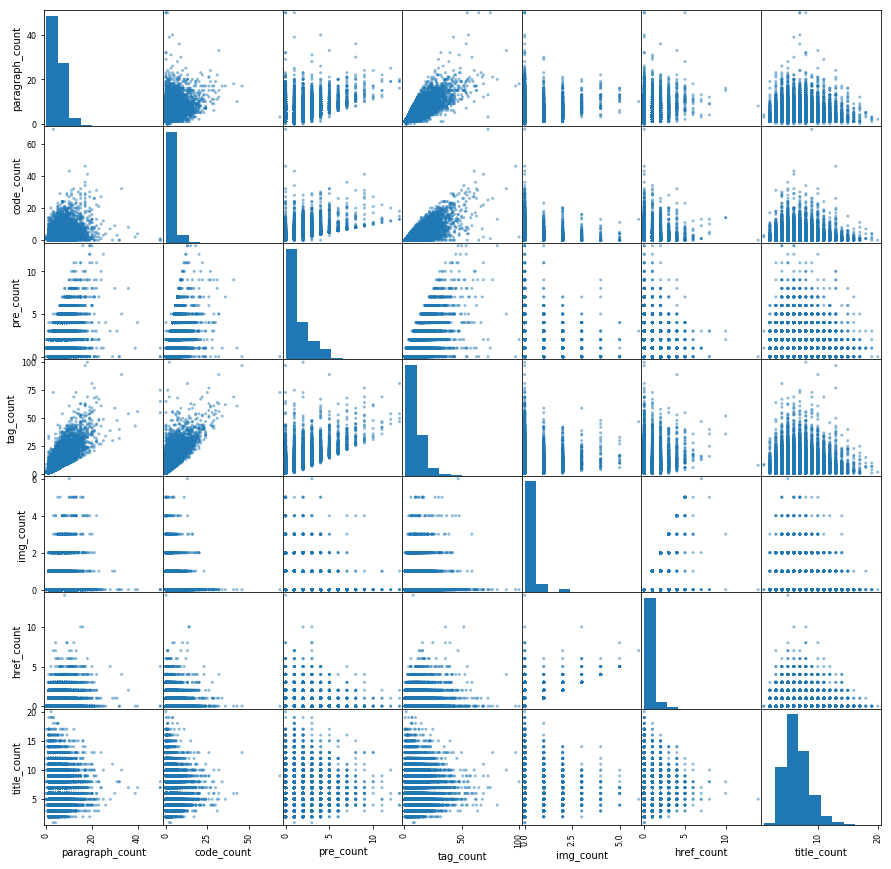

In [99]:
# plot scatter matrix for all text measures.
pd.plotting.scatter_matrix(questions_text.sample(frac=0.01)[
    ['paragraph_count', 'code_count', 'pre_count', 'tag_count', 
     'img_count', 'href_count', 'title_count']
], figsize = (15, 15))
plt.show()

In [115]:
print(np.mean(questions_text['is_question']))
print(np.mean(questions_text['is_thankful']))

0.3390559173305722
0.3014914605178163


There is an outlier that has more than 200 paragraphs in single post, let's find it and see which one it is.

In [44]:
par_list = [count_paragraph(txt) for txt in questions_text.Body]
max_value = max(par_list)
max_index = par_list.index(max_value)
print(max_index)

519953


In [47]:
questions_text.iloc[max_index].Id

42823339

https://stackoverflow.com/questions/42823339/in-django-let-me-know-drop-down-list

In [50]:
max_value = max(questions_text['href_count'])
max_index = list(questions_text['href_count']).index(max_value)
print(questions_text.iloc[max_index].Id)

42747930


Here is the post with the most hyperlinks in 2017...
https://stackoverflow.com/questions/42747930/avoid-cdn-fonts-delivery-using-wp-supercache-and-css

Merge this dataset with questions dataset to get final analysis dataset.

In [51]:
questions_text.head()

,Id,Body,Title,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,has_questionmark
0,41412454,<p>I have a problem with the following piece o...,Update on 2 or more tables,3,2,2,7,0,0,3,False
1,41412456,"<p>I am using fabric, which is a deployment to...",A expect script with multiple shell statements,5,5,1,11,0,0,6,False
2,41412462,"<p>To recreate the issue, I forked the Angular...",While bootstrapping a hybrid angular 1 + 2 app...,10,6,5,22,0,0,11,True
3,41412463,<p>I have a global variable\r\n<code>global.lo...,Is Javascript's setInterval killed when the pa...,4,7,2,13,0,0,7,True
4,41412466,<p>I have an android app to show <code>Karaoke...,Adapter not notifyDataSetChanged immediately?,5,7,2,14,0,1,3,True


In [91]:
questions = questions.reset_index()
questions['Tag_Doc'] = tags_doc_list
questions.head()

,level_0,index,CreationDate,Id,Tags,LastActivityDate,ClosedDate,AnswerCount,CommentCount,FavoriteCount,ViewCount,Score,AcceptedAnswerId,OwnerUserId,Tag_Doc
0,0,0,2008-07-31 21:42:52.667,4,<c#><winforms><type-conversion><decimal><opacity>,2017-09-27 05:52:59.927,NaT,13,1,37,33648,528,7,8,c# winforms type-conversion decimal opacity
1,1,1,2008-07-31 22:08:08.620,6,<html><css><css3><internet-explorer-7>,2016-03-19 06:10:52.170,NaT,5,0,9,15363,231,31,9,html css css3 internet-explorer-7
2,2,2,2008-07-31 23:40:59.743,9,<c#><.net><datetime>,2017-11-07 11:12:32.963,NaT,61,10,356,417633,1624,1404,1,c# .net datetime
3,3,3,2008-07-31 23:55:37.967,11,<c#><datetime><time><datediff><relative-time-s...,2017-09-04 01:27:10.793,NaT,34,3,526,126480,1234,1248,1,c# datetime time datediff relative-time-span
4,4,4,2008-08-01 00:42:38.903,13,<javascript><html><browser><timezone><timezone...,2017-07-31 11:30:41.573,NaT,24,4,127,146275,512,0,9,javascript html browser timezone timezoneoffset


In [76]:
q_and_a.head()

,CreationDate,Id,AcceptedAnswerId,IdAnswer,FirstAnswerDate,IdAcceptedAnswer,FirstAcceptedAnswerDate,TimeToFirstAnswer,TimeToFirstAcceptedAnswer,Year
0,2008-07-31 21:42:52.667,4,7,7.0,2008-07-31 22:17:57.883,7.0,2008-07-31 22:17:57.883,00:35:05.216000,0 days 00:35:05.216000,2008
1,2008-07-31 22:08:08.620,6,31,31.0,2008-08-01 12:22:51.593,31.0,2008-08-01 12:22:51.593,14:14:42.973000,0 days 14:14:42.973000,2008
2,2008-07-31 23:40:59.743,9,1404,21.0,2008-08-01 08:57:27.280,1404.0,2008-08-04 16:50:06.170,09:16:27.537000,3 days 17:09:06.427000,2008
3,2008-07-31 23:55:37.967,11,1248,12.0,2008-07-31 23:56:41.303,1248.0,2008-08-04 13:57:26.097,00:01:03.336000,3 days 14:01:48.130000,2008
4,2008-08-01 00:42:38.903,13,0,29.0,2008-08-01 12:19:17.417,NaN,NaT,11:36:38.514000,NaT,2008


In [116]:
final_df = \
    questions_text[['Id', 'paragraph_count', 'code_count', 'pre_count', 'tag_count',
                    'img_count', 'href_count', 'title_count', 'is_question', 'is_thankful']].merge(
    questions[['Id', 'Tag_Doc']], on = 'Id', how = 'inner').merge(
    q_and_a[['Id', 'CreationDate', 'AcceptedAnswerId', 'TimeToFirstAnswer', 'TimeToFirstAcceptedAnswer']],
        on = 'Id', how = 'inner')

In [93]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325297 entries, 0 to 2325296
Data columns (total 14 columns):
Id                           int64
paragraph_count              int64
code_count                   int64
pre_count                    int64
tag_count                    int64
img_count                    int64
href_count                   int64
title_count                  int64
has_questionmark             bool
Tag_Doc                      object
CreationDate                 datetime64[ns]
AcceptedAnswerId             int64
TimeToFirstAnswer            timedelta64[ns]
TimeToFirstAcceptedAnswer    timedelta64[ns]
dtypes: bool(1), datetime64[ns](1), int64(9), object(1), timedelta64[ns](2)
memory usage: 250.6+ MB


In [117]:
final_df.head()

,Id,paragraph_count,code_count,pre_count,tag_count,img_count,href_count,title_count,is_question,is_thankful,Tag_Doc,CreationDate,AcceptedAnswerId,TimeToFirstAnswer,TimeToFirstAcceptedAnswer
0,41412454,3,2,2,7,0,0,3,False,False,postgresql grails gsp,2017-01-01 00:00:04.523,0,NaT,NaT
1,41412456,5,5,1,11,0,0,6,False,False,python shell expect,2017-01-01 00:00:39.710,41412707,0 days 01:10:25.040000,01:10:25.040000
2,41412462,10,6,5,22,0,0,11,True,True,angularjs provider hybrid,2017-01-01 00:02:06.737,0,68 days 11:10:58.046000,NaT
3,41412463,4,7,2,13,0,0,7,True,False,javascript node.js,2017-01-01 00:02:29.813,41412502,0 days 00:11:58.947000,00:11:58.947000
4,41412466,5,7,2,14,0,1,3,True,False,android dataset adapter android-adapter change...,2017-01-01 00:03:28.577,0,NaT,NaT


Check time to first accepted answer by if title was stated as a question or not.

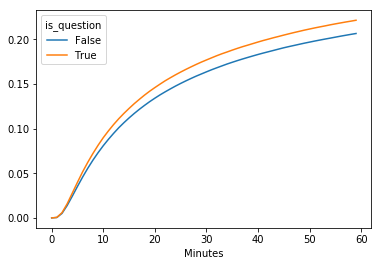

In [119]:
plot_data = pd.concat([final_df.groupby('is_question')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['is_question', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='is_question', values='Cumulative_Percentage').plot()
plt.show()

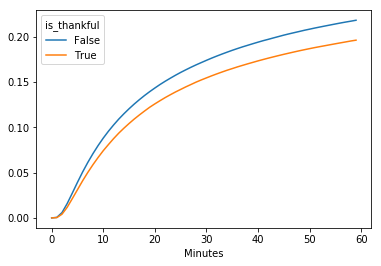

In [120]:
plot_data = pd.concat([final_df.groupby('is_thankful')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['is_thankful', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='is_thankful', values='Cumulative_Percentage').plot()
plt.show()

In [ ]:
final_df.to_csv(file_path+"final_df.csv")

Drafts Below

In [192]:
%%time
melt_list = []
for i, item in enumerate(tags_list):
    melt_list += [[i, tag, 1] for tag in item if tag in counter_common]
melt_df = pd.DataFrame(melt_list, columns = ['ind', 'tag', 'count'])
df_matrix = pd.pivot_table(melt_df, index='ind', columns='tag', values='count')

CPU times: user 2min 15s, sys: 3min 22s, total: 5min 38s
Wall time: 5min 54s


In [189]:
def create_sim_matrix(df_matrix):
    matrix = np.array(pd.DataFrame(df_matrix).fillna(0))
    n = len(df_matrix.columns)
    sim_matrix = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            sim_matrix[i][j] = 1-cosine(matrix[:, i],matrix[:, j])
    sim_df = pd.DataFrame(sim_matrix, columns=df_matrix.columns, index=df_matrix.columns)
    return(sim_df)

In [193]:
%%time
sim_df = create_sim_matrix(df_matrix)

CPU times: user 1h 15min 29s, sys: 1h 1min 22s, total: 2h 16min 51s
Wall time: 1h 1min 26s


In [205]:
corr = sim_df.loc[most_common_100, most_common_100]

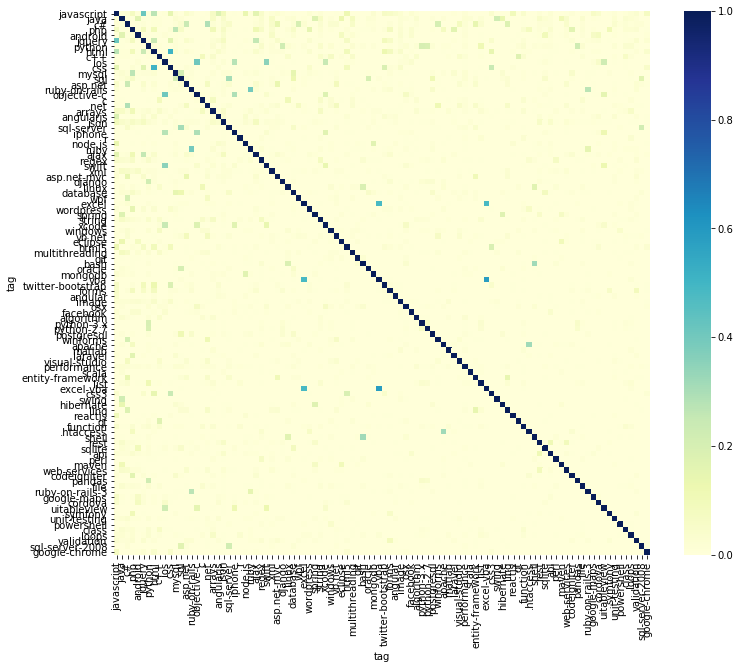

In [210]:
fig, ax = plt.subplots(figsize=(12,10))
sns.diverging_palette
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap="YlGnBu")

In [215]:
sim_df.loc[most_common_100[0:20], most_common_100[0:20]]

tag,javascript,java,c#,php,android,jquery,python,html,c++,ios,css,mysql,sql,asp.net,ruby-on-rails,objective-c,c,.net,arrays,angularjs
tag,,,,,,,,,,,,,,,,,,,,
javascript,1.000000,0.011443,0.016383,0.077709,0.010532,0.417101,0.007277,0.273060,0.001467,0.009290,0.149644,0.014105,0.002859,0.043023,0.020486,0.001691,0.000638,0.004875,0.065827,0.183695
java,0.011443,1.000000,0.005639,0.005313,0.165007,0.004483,0.004384,0.011327,0.007966,0.001545,0.002996,0.027682,0.017437,0.000848,0.000705,0.001232,0.005589,0.003337,0.061816,0.003511
c#,0.016383,0.005639,1.000000,0.002292,0.006889,0.014869,0.001815,0.011714,0.011128,0.003628,0.003545,0.012827,0.037517,0.240219,0.000167,0.000920,0.003070,0.290391,0.021930,0.004002
php,0.077709,0.005313,0.002292,1.000000,0.009622,0.083152,0.003715,0.100076,0.001382,0.003542,0.022851,0.268993,0.057335,0.002471,0.001204,0.001740,0.001436,0.001455,0.104960,0.008009
android,0.010532,0.165007,0.006889,0.009622,1.000000,0.003547,0.002568,0.007192,0.006030,0.017203,0.004369,0.007963,0.004664,0.001463,0.000773,0.000670,0.003061,0.001246,0.010519,0.003167
jquery,0.417101,0.004483,0.014869,0.083152,0.003547,1.000000,0.003332,0.239589,0.000066,0.003265,0.169357,0.015035,0.002127,0.044786,0.021871,0.000120,0.000052,0.003782,0.022740,0.031455
python,0.007277,0.004384,0.001815,0.003715,0.002568,0.003332,1.000000,0.013191,0.009243,0.000801,0.002062,0.015297,0.007702,0.000479,0.000654,0.000627,0.007681,0.001136,0.030261,0.001605
html,0.273060,0.011327,0.011714,0.100076,0.007192,0.239589,0.013191,1.000000,0.000800,0.006404,0.508034,0.023608,0.005873,0.025125,0.009475,0.001536,0.000554,0.003616,0.009300,0.044509
c++,0.001467,0.007966,0.011128,0.001382,0.006030,0.000066,0.009243,0.000800,1.000000,0.003438,0.000313,0.002767,0.001459,0.000294,0.000124,0.004955,0.086314,0.005491,0.049790,0.000044


This is mainly to check if there were very strongly correlated tags. Among the top 20 common tags, we can see some patterns, such as `html` and `css` are strongly associated. Running a simply clustering algorithm to capture such patterns.

In [259]:
from sklearn.cluster import SpectralClustering
cid = SpectralClustering(affinity='precomputed',n_clusters=20).fit_predict(sim_df.loc[most_common_100, most_common_100])

In [268]:
cluster_dict = dict()
for i in np.arange(min(cid), max(cid)):
    cluster_dict[most_common_100[cid == i][0]] = most_common_100[cid == i].tolist()
cluster_dict    

{'javascript': ['javascript',
  'jquery',
  'asp.net',
  'angularjs',
  'json',
  'ajax',
  'xml',
  'angular',
  'reactjs',
  'unit-testing'],
 'java': ['java', 'multithreading', 'image', 'swing'],
 'sql': ['sql', 'database', 'spring', 'oracle', 'postgresql', 'hibernate'],
 'python': ['python', 'django', 'python-3.x', 'python-2.7', 'pandas'],
 'sql-server': ['sql-server', 'sql-server-2008'],
 'apache': ['apache', '.htaccess'],
 'eclipse': ['eclipse', 'git', 'maven'],
 'c++': ['c++', 'qt'],
 'ios': ['ios',
  'objective-c',
  'iphone',
  'swift',
  'xcode',
  'osx',
  'uitableview'],
 'excel': ['excel', 'vba', 'excel-vba'],
 'rest': ['rest', 'api', 'web-services'],
 'php': ['php',
  'mysql',
  'wordpress',
  'forms',
  'laravel',
  'codeigniter',
  'symfony',
  'validation'],
 'asp.net-mvc': ['asp.net-mvc', 'entity-framework', 'linq'],
 'c#': ['c#',
  '.net',
  'wpf',
  'windows',
  'vb.net',
  'winforms',
  'visual-studio',
  'powershell'],
 'html': ['html',
  'css',
  'html5',
  'twit

So far the clustering result seems reasonable. This will help to reduce number of topics for questions we have. Re-visit some trends above spliting by each topic group.

In [275]:
def get_tag_cluster(cluster_name, tags_list):
    return([not set(tags).isdisjoint(cluster_dict[cluster_name]) for tags in tags_list])

In [282]:
%%time
cluster_lst = [get_tag_cluster(cluster_name, tags_list) for cluster_name in cluster_dict.keys()]

CPU times: user 2min 49s, sys: 27.4 s, total: 3min 17s
Wall time: 3min 37s


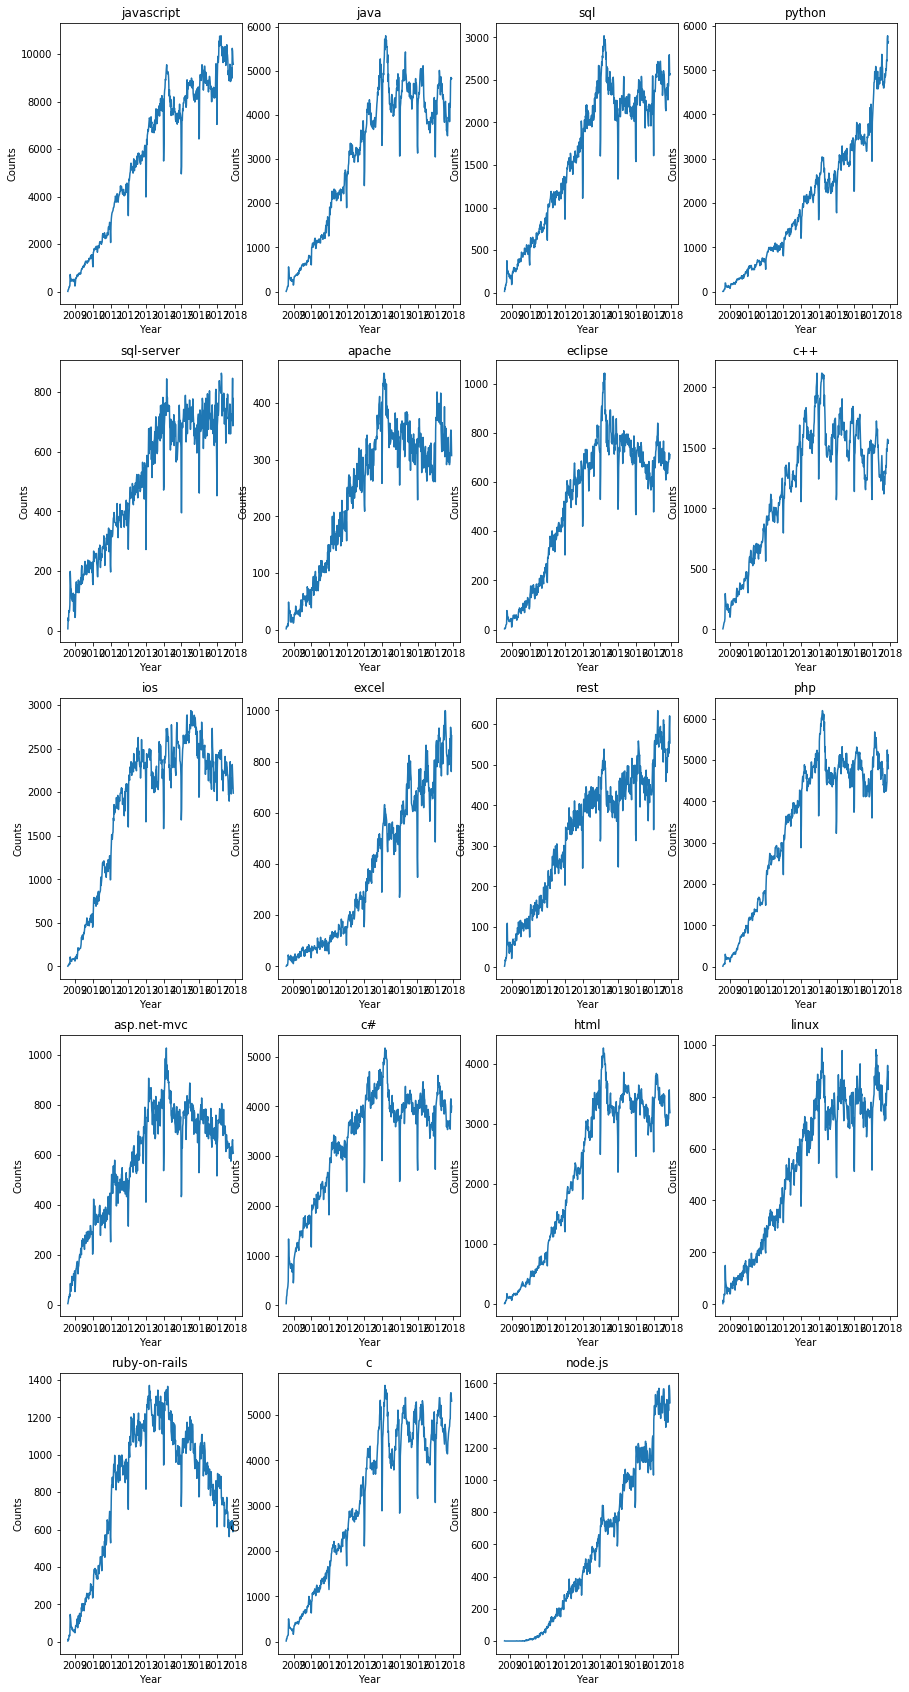

In [294]:
plt.subplots(figsize = (15, 30))
for i, item in enumerate(list(cluster_dict.keys())):
    plt.subplot(5, 4, i + 1)
    plt.plot(questions['Id'][cluster_lst[i]].resample('W').count())
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.title(item)
plt.show()

/Users/ouou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


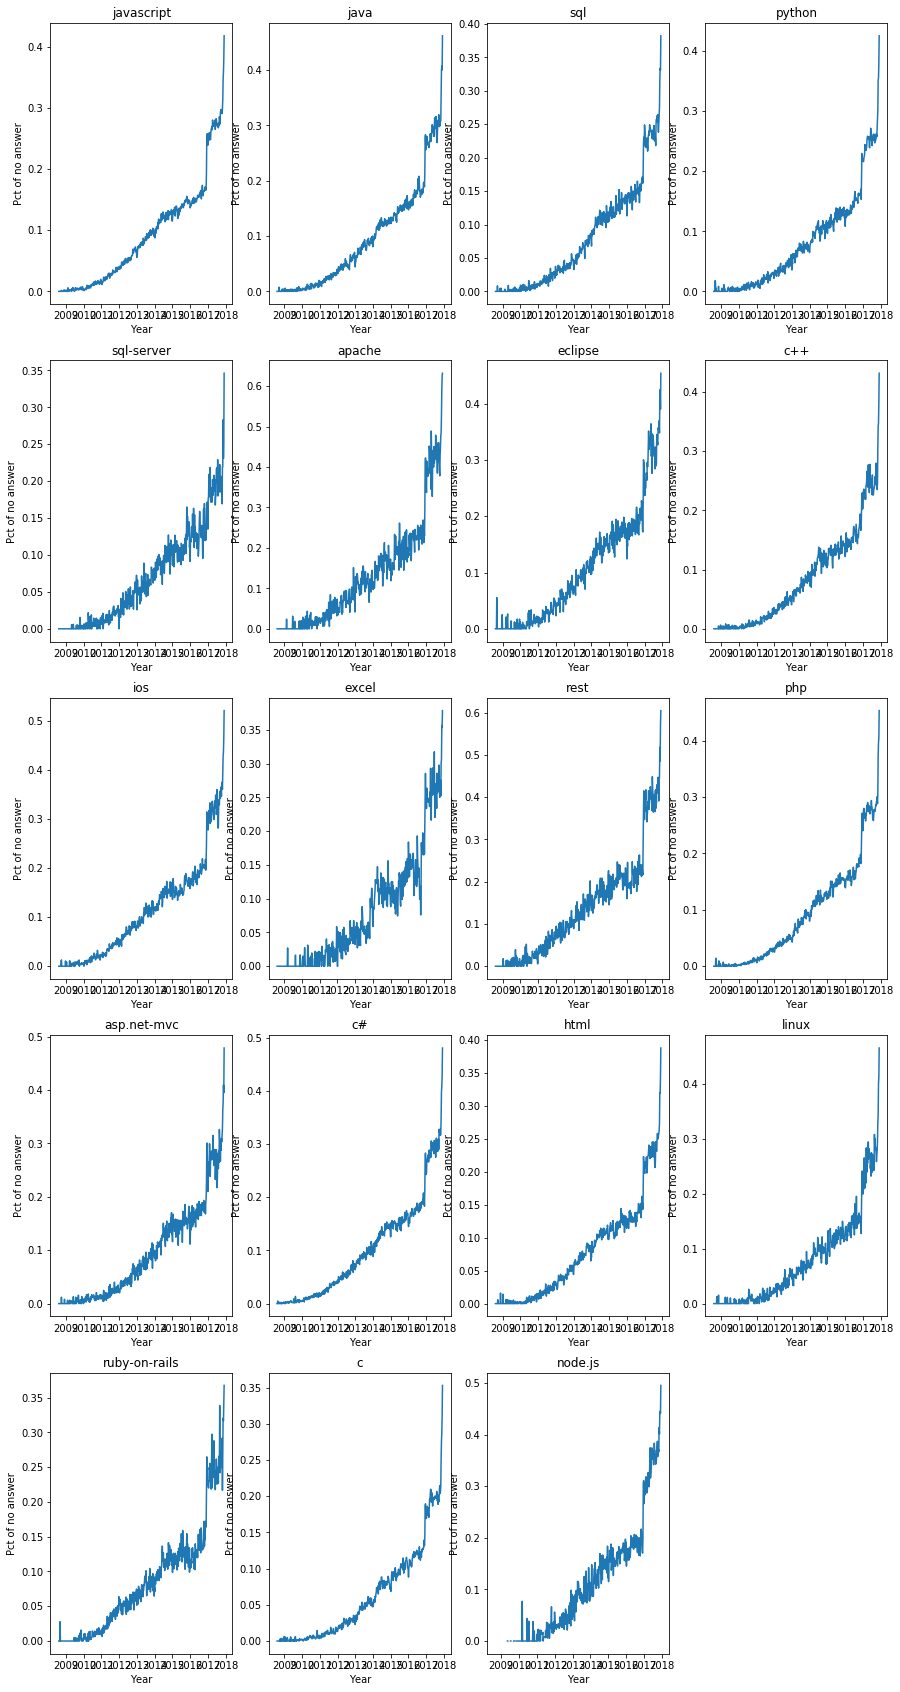

In [295]:
plt.subplots(figsize = (15, 30))
for i, item in enumerate(list(cluster_dict.keys())):
    plt.subplot(5, 4, i + 1)
    plt.plot(questions[cluster_lst[i]].resample('W').AnswerCount.apply(get_no_answer_pct))
    plt.xlabel('Year')
    plt.ylabel('Pct of no answer')
    plt.title(item)
plt.show()

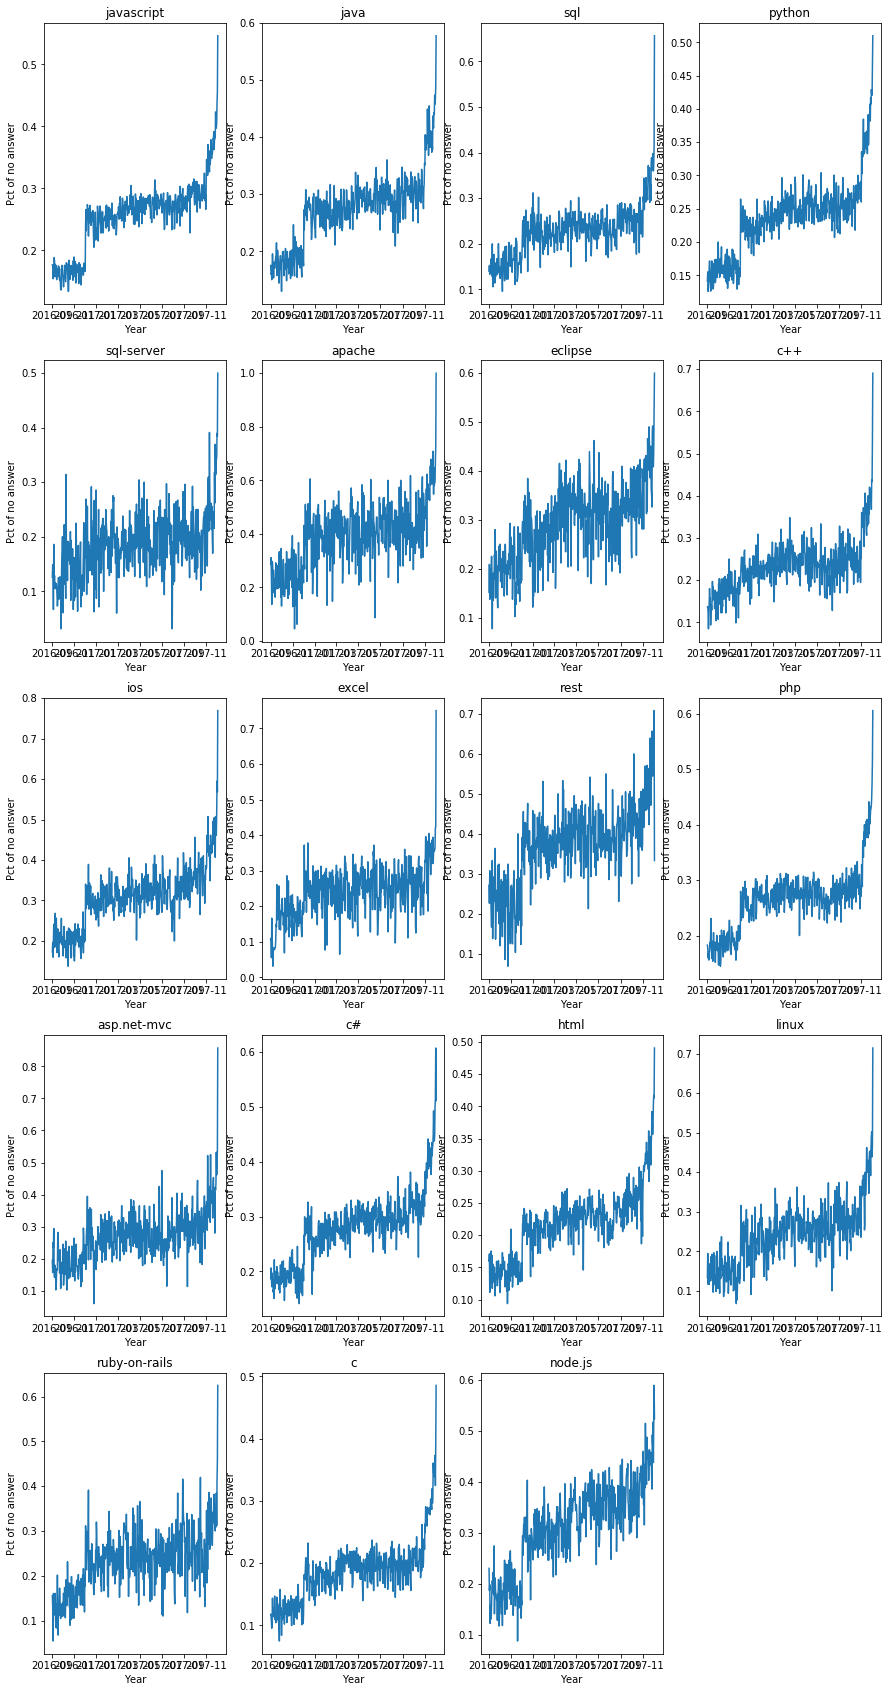

In [296]:
plt.subplots(figsize = (15, 30))
for i, item in enumerate(list(cluster_dict.keys())):
    plt.subplot(5, 4, i + 1)
    plt.plot(questions[cluster_lst[i]]["2016-09":"2017-12"].resample('D').AnswerCount.apply(get_no_answer_pct))
    plt.xlabel('Year')
    plt.ylabel('Pct of no answer')
    plt.title(item)
plt.show()

Looking at number of questions, different categories follow mostly the same trend, with some start declining and lose interest among the community (ruby) and some increased even further (python, javascript, node.js).

There is some but not too much different regarding how likely were questions got answered. A lot questions are expected to be answered within a month, otherwise will hardly find an answer in short term. The weird jump at around Jan 2017 exist for all categories of questions. Some categories are easier to find an answer (sql, sql-server, c(including a bunch of basic tags), 80% answer rate at first month), while questions from some other categories are harder (apache, 60% answer rate at first month).

### Users
Users can be an interesting but separate topic. There is no plan to closely looking into users dataset, here just trying to extract location information for each user.

In [298]:
%%time
users = pd.read_csv(file_path+"user.csv", index_col="Id", 
                    parse_dates=["CreationDate", "LastAccessDate"])

/Users/ouou/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 36.6 s, sys: 7.87 s, total: 44.4 s
Wall time: 48 s


In [300]:
users.Location.describe()

count     1681659
unique     121224
top         India
freq        41377
Name: Location, dtype: object

In [323]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [315]:
loc_str = [str.strip(str(loc).split(',')[-1]) for loc in users.Location]

In [432]:
loc_str = ["United States" if loc in states.keys() else loc for loc in loc_str]
loc_str = ["United States" if loc in states.values() else loc for loc in loc_str]
loc_str = ["United States" if loc == "USA" else loc for loc in loc_str]
loc_str = ["United Kingdom" if loc == "UK" else loc for loc in loc_str]
loc_str = ["United Kingdom" if loc == "UK" else loc for loc in loc_str]
loc_str = ["China" if loc[-4:] == " Shi" else loc for loc in loc_str]
loc_str = ["China" if loc == "china" else loc for loc in loc_str]
# aggregate into bigger regions
loc_str = ['NA' if loc in ["United States", "Canada", 'Mexico', 'México'] else loc for loc in loc_str]
loc_str = ['EA' if loc in ["China", "Indonesia", "Philippines", "Singapore", 
                           "Taiwan", "South Korea", "Malaysia", 'Vietnam', 'Việt Nam', 'Hong Kong',
                          'Thailand', 'Chennai', 'Japan', "Hong Kong"] else loc for loc in loc_str]
loc_str = ['SA' if loc in ["India", "Pakistan", "Bangladesh", "Sri Lanka", 'Iran', 
                           'Nepal', "Delhi", "New Delhi"] else loc for loc in loc_str]
loc_str = ['EU' if loc in ["United Kingdom", "Germany", "France", "Russia", 
                           'Netherlands', "Poland", "Ukraine",
                          "Spain", "Italy", "Sweden", "Deutschland",
                          "Romania", "Belgium", "Switzerland", "Portugal",
                          "Polska", "Ireland", "Italia", "Türkiye", 'Turkey', 'Israel', 
                           "Denmark", "España", "Norway", "Greece",
                           "Austria", "Finland", "Czech Republic", "Bulgaria",
                            "London", "Belarus", "Hungary", "Nederland"] else loc for loc in loc_str]


In [433]:
Counter(loc_str).most_common(20)

[('nan', 6442278),
 ('EU', 409114),
 ('NA', 384157),
 ('SA', 312549),
 ('EA', 137265),
 ('Australia', 28370),
 ('Brazil', 21055),
 ('Brasil', 15045),
 ('Download Link:', 14388),
 ('South Africa', 10288),
 ('Egypt', 10171),
 ('Argentina', 8070),
 ('New Zealand', 6762),
 ('Nigeria', 6333),
 ('Colombia', 5363),
 ('Bangalore', 5305),
 ('Россия', 5242),
 ('Chile', 3845),
 ('Kenya', 3639),
 ('Morocco', 2827)]

In [345]:
users.head(10)

,AccountId,DisplayName,Age,CreationDate,LastAccessDate,Location,Reputation,UpVotes,DownVotes,Views
Id,,,,,,,,,,
-1,-1,Community,NaN,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,on the server farm,1,225495,890820,649
1,1,Jeff Atwood,47.0,2008-07-31 14:22:31.287,2017-11-13 11:01:24.840,"El Cerrito, CA",42510,3348,1308,327890
2,2,Geoff Dalgas,40.0,2008-07-31 14:22:31.287,2017-12-01 22:41:28.983,"Corvallis, OR",3200,642,88,22508
3,3,Jarrod Dixon,38.0,2008-07-31 14:22:31.287,2017-12-02 07:08:31.943,"Raleigh, NC, United States",13138,7003,100,23373
4,4,Joel Spolsky,NaN,2008-07-31 14:22:31.317,2017-12-02 00:28:55.120,"New York, NY",27792,786,96,71109
5,5,Jon Galloway,47.0,2008-07-31 14:22:31.317,2017-11-30 21:05:02.703,"San Diego, CA",37634,780,34,10978
8,6,Eggs McLaren,NaN,2008-07-31 21:33:24.057,2012-10-15 22:00:45.510,NaN,942,12,9,5914
9,7,Kevin Dente,46.0,2008-07-31 21:35:26.517,2017-11-30 23:00:29.633,"Oakland, CA",13314,45,4,4528
10,8,Sneakers O'Toole,38.0,2008-07-31 21:57:06.240,2012-06-19 19:35:43.433,"Lakehead, CA",101,0,0,3389


In [340]:
users.describe()

,AccountId,Age,Reputation,UpVotes,DownVotes,Views
count,8.123937e+06,701955.000000,8.123937e+06,8.123937e+06,8.123937e+06,8.123937e+06
mean,6.129152e+06,30.798822,1.130989e+02,1.214454e+01,1.547752e+00,1.449911e+01
std,3.572510e+06,8.682574,2.236946e+03,1.632540e+02,3.254881e+02,6.601804e+02
min,-1.000000e+00,5.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.048437e+06,25.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.022259e+06,29.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.251048e+06,34.000000,8.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
max,1.241585e+07,147.000000,9.904020e+05,2.254950e+05,8.908200e+05,1.499608e+06


In [438]:
users['LocationCleaned'] = loc_str

In [439]:
plot_df = pd.merge(questions[['OwnerUserId']].reset_index(),
                  users[['LocationCleaned']].reset_index(),
                  left_on = "OwnerUserId", right_on = "Id", )
plot_df = plot_df.set_index('CreationDate')["2013":"2017"]
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10934844 entries, 2013-10-16 17:16:29.257000 to 2017-12-03 05:00:08.563000
Data columns (total 3 columns):
OwnerUserId        int64
Id                 int64
LocationCleaned    object
dtypes: int64(2), object(1)
memory usage: 333.7+ MB


In [442]:
top_countries = ['EU', 'NA', 'SA', 'EA']
plot_counts = plot_df[plot_df.LocationCleaned.isin(top_countries)] \
    .groupby('LocationCleaned').resample('H')[['Id']].count()
plot_counts.columns = ['Count']
plot_counts = plot_counts.reset_index().set_index('CreationDate')
plot_counts['DayOfWeek'] = plot_counts.index.dayofweek
plot_counts['Hour'] = plot_counts.index.hour
weekday_hourly = plot_counts[plot_counts.DayOfWeek<5].groupby(['LocationCleaned', 'Hour']) \
    .Count.median().reset_index()
weekend_hourly = plot_counts[plot_counts.DayOfWeek>=5].groupby(['LocationCleaned', 'Hour']) \
    .Count.median().reset_index()

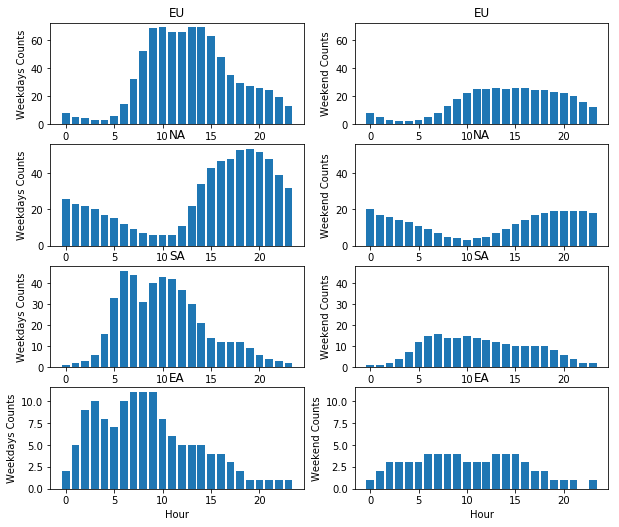

In [443]:
plt.subplots(figsize=(10, 22))
for i, country in enumerate(top_countries):
    ax = plt.subplot(10, 2, 2*i+1)
    plt.bar(weekday_hourly[weekday_hourly.LocationCleaned == country].Hour, 
            weekday_hourly[weekday_hourly.LocationCleaned == country].Count)
    plt.xlabel('Hour')
    plt.ylabel('Weekdays Counts')
    plt.title(country)
    plt.subplot(10, 2, 2*i+2, sharey=ax)
    plt.bar(weekend_hourly[weekend_hourly.LocationCleaned == country].Hour, 
            weekend_hourly[weekend_hourly.LocationCleaned == country].Count)
    plt.xlabel('Hour')
    plt.ylabel('Weekend Counts')
    plt.title(country)
plt.show()

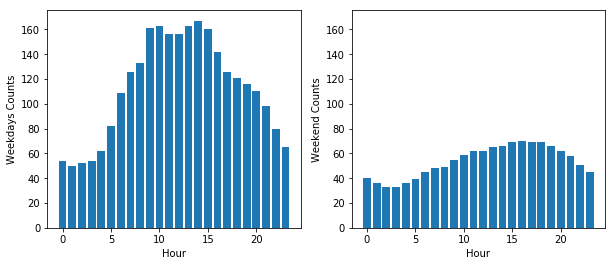

In [444]:
plot_counts = plot_df[plot_df.LocationCleaned != "nan"].resample('H')[['Id']].count()
plot_counts.columns = ['Count']
plot_counts = plot_counts.reset_index().set_index('CreationDate')
plot_counts['DayOfWeek'] = plot_counts.index.dayofweek
plot_counts['Hour'] = plot_counts.index.hour
weekday_hourly = plot_counts[plot_counts.DayOfWeek<5].groupby(['Hour']).Count.median().reset_index()
weekend_hourly = plot_counts[plot_counts.DayOfWeek>=5].groupby(['Hour']).Count.median().reset_index()
plt.subplots(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
plt.bar(weekday_hourly.Hour, 
        weekday_hourly.Count)
plt.xlabel('Hour')
plt.ylabel('Weekdays Counts')
plt.subplot(1, 2, 2, sharey=ax)
plt.bar(weekend_hourly.Hour, 
        weekend_hourly.Count)
plt.xlabel('Hour')
plt.ylabel('Weekend Counts')
plt.show()

Basically, this is a joint distribution of daily activity time. It peaks at UTC = 10 - 15 mainly because EU has the largest user basis than all other regions.

Tags Analysis
Location
Text Features

Modeling
Tags Clustering
